In [1]:
import os
import gc, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [2]:
def feature_engineering(is_train=True,debug=True):
    if is_train: 
        print("processing train.csv")
        if debug == True:
            df = pd.read_csv('train_V2.csv', nrows=10000)
        else:
            df = pd.read_csv('train_V2.csv')           

        df = df[df['maxPlace'] > 1]
    else:
        print("processing test.csv")
        df = pd.read_csv('test_V2.csv')
    
    print("remove some columns")
    target = 'winPlacePerc'

    print("Adding Features")
 
#     df['headshotrate'] = df['kills']/df['headshotKills']
#     df['killStreakrate'] = df['killStreaks']/df['kills']
#     df['healthitems'] = df['heals'] + df['boosts']
#     df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
#     df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
#     df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
#     df['distance_over_weapons'] = df['totalDistance'] / df['weaponsAcquired']
#     df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
#     df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
#     df['killsPerWalkDistance'] = df['kills'] / df['walkDistance']
#     df["skill"] = df["headshotKills"] + df["roadKills"]

    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    
    print("Removing Na's From DF")
    df.fillna(0, inplace=True)

    
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove("matchType")
    
    y = None
    
    if is_train: 
        print("get target")
        y = df.groupby(['matchId','groupId'])[target].agg('mean')
        features.remove(target)

    print("get group mean feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    if is_train: df_out = agg.reset_index()[['matchId','groupId']]
    else: df_out = df[['matchId','groupId']]

    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group max feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group min feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group size feature")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("get match mean feature")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])

    print("get match size feature")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)

    X = df_out
    
    del df_out, agg, agg_rank
    gc.collect()

    return X, y

In [42]:
def feature_added_engineering(is_train=True,debug=True):
    if is_train: 
        print("processing train.csv")
        if debug == True:
            df = pd.read_csv('train_V2.csv', nrows=10000)
        else:
            df = pd.read_csv('train_V2.csv')           

        df = df[df['maxPlace'] > 1]
    else:
        print("processing test.csv")
        df = pd.read_csv('test_V2.csv')
    target = 'winPlacePerc'
    print("remove some columns")
    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    
    print("Adding Features")
    df = df.assign(team_size=df.groupby('groupId').groupId.transform('count'))
    df = df.assign(max_team_size=df.groupby('matchId').team_size.transform('max'))
    df= df.assign(match_size=df.groupby('matchId').matchId.transform('nunique'))

    df['max_possible_kills'] = df.match_size - df.team_size
    df['total_distance'] = df.rideDistance + df.swimDistance + df.walkDistance
    df['total_items_acquired'] = df.boosts + df.heals + df.weaponsAcquired
    df['items_per_distance'] =  df.total_items_acquired/df.total_distance
    df['kills_per_distance'] = df.kills/df.total_distance
    df['knocked_per_distance'] = df.DBNOs/df.total_distance
    df['damage_per_distance'] = df.damageDealt/df.total_distance
    df['headshot_kill_rate'] = df.headshotKills/df.kills
    df['max_kills_by_team'] = df.groupby('groupId').kills.transform('max')
    df['total_team_damage'] = df.groupby('groupId').damageDealt.transform('sum')
    df['total_team_kills'] =  df.groupby('groupId').kills.transform('sum')
    df['total_team_items'] = df.groupby('groupId').total_items_acquired.transform('sum')
    df['pct_killed'] = df.kills/df.max_possible_kills
    df['pct_knocked'] = df.DBNOs/df.max_possible_kills
    df['pct_team_killed'] = df.total_team_kills/df.max_possible_kills
    df['team_kill_points'] = df.groupby('groupId').killPoints.transform('sum')
    df['team_kill_rank'] = df.groupby('groupId').killPlace.transform('mean')
    df['max_kills_match'] = df.groupby('matchId').kills.transform('max')
    df['total_kills_match'] = df.groupby('matchId').kills.transform('sum')
    df['total_distance_match'] = df.groupby('matchId').total_distance.sum()
    df['map_has_sea'] =  df.groupby('matchId').swimDistance.transform('sum').apply(lambda x: 1 if x>0 else 0)
    
    print("remove some columns")
    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    
    print("Removing Na's From DF")
    df.fillna(0, inplace=True) 
    
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove("matchType")
    features.remove("team_size")
    features.remove("max_team_size")
    features.remove("match_size")
    features.remove("map_has_sea")
    
    y = None
    
    if is_train: 
        print("get target")
        y = df.groupby(['matchId','groupId'])[target].agg('mean')
        features.remove(target)

    print("get group mean feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    if is_train: df_out = agg.reset_index()[['matchId','groupId']]
    else: df_out = df[['matchId','groupId']]

    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
#     df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
    
   
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)

    X = df_out
    
#     del df, df_out, agg, agg_rank
#     gc.collect()

    return X, y

In [54]:
x_train, y_train = feature_engineering(True,False)
# x_train, y_train = feature_added_engineering(True,False)
#x_test, _ = feature_engineering(False,True)


processing train.csv
remove some columns
Adding Features
Removing Na's From DF
get target
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature


In [51]:
print(x_train.shape)
print(y_train.shape)

# for i in x_train.columns:
#     print(i)

(831138, 44)
(831138,)


# Data Splitting

In [52]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, yTrain, yTest = train_test_split(x_train, y_train, test_size = 0.2, shuffle=False)

# print(np.sum(np.isnan(Xtrain)))
std_scaler = StandardScaler().fit(Xtrain)
Xtrain = std_scaler.transform(Xtrain)
Xtest = std_scaler.transform(Xtest)

### Feature Similarity Matrix

(664910, 44)
[[1.         0.31340006 0.41652793 ... 0.05583148 0.07193803        nan]
 [0.31340006 1.         0.53945535 ... 0.044672   0.05622081        nan]
 [0.41652793 0.53945535 1.         ... 0.14375566 0.17264817        nan]
 ...
 [0.05583148 0.044672   0.14375566 ... 1.         0.62114411        nan]
 [0.07193803 0.05622081 0.17264817 ... 0.62114411 1.                nan]
 [       nan        nan        nan ...        nan        nan        nan]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


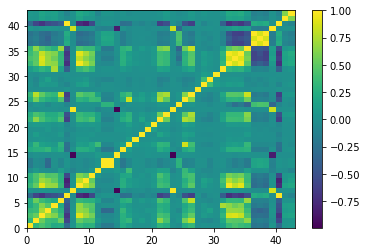

In [53]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors
print(Xtrain.shape)
corr = np.corrcoef(Xtrain, rowvar=False)
print(corr)
num_features = Xtrain.shape[1]
plt.pcolormesh(np.arange(num_features), np.arange(num_features), corr, norm=colors.PowerNorm(gamma=1))
plt.colorbar()
plt.show()

### PCA

In [48]:
from sklearn.decomposition import PCA

pca = PCA(0.95).fit(Xtrain)
Xtrain_new = pca.fit_transform(Xtrain)
Xtest_new = pca.fit_transform(Xtest)
# print(pca.explained_variance_ratio_) 
# print(pca.singular_values_)
print(Xtrain.shape)
print(Xtrain_new.shape)

# sum = 0
# ind = 1
# for i in pca.explained_variance_ratio_:
#     sum = sum + i
#     ind = ind + 1
#     if sum > 0.95:
#         print('Explanation reach to 95% at' + str(ind))
#         Xtrain_pca = Xtrain_new[:,:ind]
#         Xtest_pca = Xtest_new[:,:ind]
#         break
#     else:
#         Xtain_pca = Xtrain_new
        
# print(Xtrain_pca.shape)

(664910, 44)
(664910, 24)


### Linear Regression

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Before PCA
model = LinearRegression()
model.fit(Xtrain, yTrain)
pred = model.predict(Xtest)
print(Xtest.shape)
print(mean_absolute_error(pred, yTest))

# After PCA
model = LinearRegression()
model.fit(Xtrain_new, yTrain)
pred = model.predict(Xtest_new)
print(mean_absolute_error(pred, yTest))

(166228, 44)
0.08624003519591435


ValueError: shapes (166228,23) and (24,) not aligned: 23 (dim 1) != 24 (dim 0)

### LDA

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

yTrain = yTrain.astype(int)
model = LinearDiscriminantAnalysis()
model.fit(Xtrain, yTrain)
pred = model.predict(Xtest)
print(mean_absolute_error(pred, yTest))


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.46874262995227806


### Neural Net

In [37]:
def nn_model(input_shape=x_train.shape[1], hidden_size=128):
    model = Sequential()
    model.add(Dense(hidden_size, input_dim=input_shape, kernel_initializer='xavier'))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(hidden_size, kernel_initializer='xavier'))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(hidden_size, kernel_initializer='xavier'))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.25))
    model.add(Dense(hidden_size, kernel_initializer='xavier'))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.25))
    model.add(Dense(1, kernel_initializer='xavier'))
    
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])
    return model

In [36]:
mlp_model = nn_model(x_train.shape[1], hidden_size=64)
history = mlp_model.fit(x_train, y_train, batch_size=128, epochs=8, verbose=1, validation_split=0.1, shuffle=True)
pred_test_mlp = mlp_model.predict(x_test)

NameError: name 'nn_model' is not defined

In [38]:
plt.plot(history.history['val_loss']);
plt.plot(history.history['loss']);

NameError: name 'history' is not defined

## Lasso

In [15]:
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import matplotlib.pyplot as plt
import matplotlib

reg = LassoCV()

reg.fit(Xtrain, yTrain)
pred = reg.predict(Xtest)
mae = mean_absolute_error(pred, yTest)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best mae using built-in LassoCV: %f" % mae)
coef = pd.Series(reg.coef_, index = x_train.columns)
coef = pd.Series(reg.coef_)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()

matplotlib.rcParams['figure.figsize'] = (32.0, 40.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best alpha using built-in LassoCV: 0.000247
Best mae using built-in LassoCV: 0.086521


TypeError: 'numpy.float64' object is not callable

## Elastic Net

In [126]:
from sklearn.linear_model import ElasticNetCV
enet_reg = ElasticNetCV(cv=5, random_state=0)
enet_reg.fit(Xtrain, yTrain)


enet_pred = enet_reg.predict(Xtest)
mae = mean_absolute_error(enet_pred, yTest)
print("Best alpha using built-in ElasticNetCV: %f" % enet_reg.alpha_)
print("Best intercept using built-in ElasticNetCV: %f" % enet_reg.intercept_)
print("Best mae using built-in ElasticNetCV: %f" % mae)
enet_coef = pd.Series(enet_reg.coef_, index = x_train.columns)

# print("Elastic Net picked " + str(sum(enet_coef != 0)) + " variables and eliminated the other " +  str(sum(enet_coef == 0)) + " variables")


Best alpha using built-in ElasticNetCV: 0.000494
Best intercept using built-in ElasticNetCV: 0.488774
Best mae using built-in ElasticNetCV: 0.086341


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## SVR

In [14]:
from sklearn.svm import SVR

for i in range (1000,10000,1000):
    model = SVR(kernel='rbf',gamma = 'auto',max_iter=i,verbose=True)
    model.fit(Xtrain, yTrain)
    pred = model.predict(Xtest)
    print('iteration = ' + str(i))
    print(mean_absolute_error(pred, yTest))

[LibSVM]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


iteration = 1000
0.13535276643649916
[LibSVM]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


iteration = 2000
0.09901935603832297
[LibSVM]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


iteration = 3000
0.10239503044949187
[LibSVM]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


iteration = 4000
0.11014833532559248
[LibSVM]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


iteration = 5000
0.11895586529042379
[LibSVM]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


iteration = 6000
0.10299156970386021
[LibSVM]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


iteration = 7000
0.09298460636606722
[LibSVM]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=8000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


iteration = 8000
0.10829636092212505
[LibSVM]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=9000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


iteration = 9000
0.08584399848342895


<function matplotlib.pyplot.show(*args, **kw)>

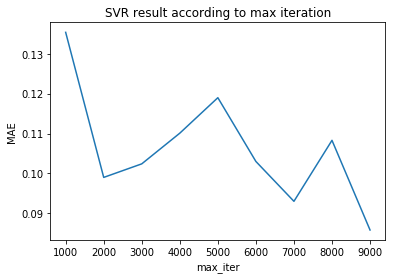

In [26]:
iter_num = np.array(range(1000,10000,1000))
svr_mae_result = np.array([0.1354, 0.0990, 0.1024,0.1101,0.1190,0.1030,0.0930,0.1083,0.0858])
plt.plot(iter_num,svr_mae_result)
plt.title('SVR result according to max iteration')
plt.ylabel('MAE')
plt.xlabel('max_iter')
plt.show